# Assignment 1
In Section AE.1 in the ebook, the NN model is trained on the normal Reynolds stresses
in the boundary layer flow and then the Reynolds stresses in the two channel
flows ($Re_τ$ = 550 and $Re_τ$ = 5 200) are predicted. Do it the other way around:
use one of the channel flows as training data and predict the Reynolds stresses for
the other two flows. You need probably change the limits on y+ and ∂U+/∂y+.

In [118]:
%load_ext autoreload
%autoreload 2

from LoadData import *
from pathlib import Path
import numpy as np
import torch 
import sys 
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from random import randrange
from joblib import dump, load

plt.rcParams.update({'font.size': 22})
plt.interactive(True)
plt.close('all')
# Create output path
outputPath = 'Output/'
Path("Output").mkdir(parents=True, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get DNS/LES data

In [119]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re550', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

Returning data from: FullyDevelopedChannel_Re550. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2]


ValueError: x and y must be the same size

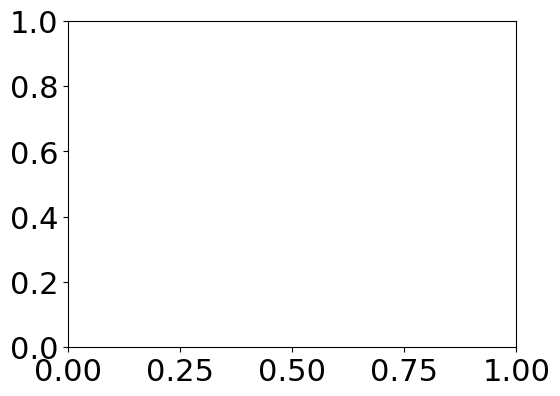

In [128]:
plot = True

if plot:
    ########################## 2*a11_DNS+a33_DNS
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    ax1.scatter(2*a11_DNS+a33_DNS,yplus_DNS, marker="o", s=10, c="red", label="Neural Network")
    plt.xlabel("$2a_{11}+a_{33}$")
    plt.ylabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/2a11_DNS+a33_DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-k-eps-units-BL.png')


    prod_DNS_1 = -uv_DNS*dudy_DNS

    ########################## k-bal
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    #ax1.plot(yplus_DNS_uu,prod_DNS, 'b-', label="prod")
    ax1.plot(yplus_DNS,prod_DNS_1, 'b-', label="$-\\overline{u'v'} \\partial U/\\partial y$")
    ax1.plot(yplus_DNS,-eps_DNS,'r--', label="-diss")
    plt.axis([0,200,0,0.3])
    plt.ylabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/prod-diss-DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-ustar-and-nu-BL.png')



In [121]:
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = k_DNS/eps_DNS
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()
scaler_dudy2 = MinMaxScaler()
scaler_dudy = MinMaxScaler()
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.fit_transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.fit_transform(dudy_DNS_inv_scaled)[:,0]



In [125]:

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility

random_state = randrange(100)

indices = np.arange(len(X))

# Set test size to 0 for now
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, indices,test_size = 0.1 ,shuffle=True,random_state=42)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

my_batch_size = 5
# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=my_batch_size)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=my_batch_size)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

# Assertions instead of plotting the data
for i, k in enumerate(index_train):
    assert abs(c_0_DNS[k] - train_dataset[i][1][0].numpy()) < 0.000001, "Training set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - train_dataset[i][1][1].numpy()) < 0.000001, "Training set for C2 differs from input values!"
    
for i, k in enumerate(index_test):
    assert abs(c_0_DNS[k] - test_dataset[i][1][0].numpy()) < 0.000001, "Test set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - test_dataset[i][1][1].numpy()) < 0.000001, "Test set for C2 differs from input values!"



In [127]:

class nn_turbML(nn.Module):

    def __init__(self, nNodes):
        super(nn_turbML, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(2, nNodes), nn.Linear(nNodes, nNodes), nn.Linear(nNodes,2)])
        self.actFunction = nn.ReLU()

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
            # No activation function on output layer
            if i == len(self.linears)-1:
                break
            x = self.actFunction(x)
        return x

def closure():
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(X)  # Forward pass through the model
        loss = loss_fn(outputs, y)  # Compute mean squared error loss

        # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)  # L1 norm of model parameters

        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization  # Add L1 regularization to the loss
        loss.backward()  # Compute gradients
    return loss
  

def test_loop(dataloader, model, loss_fn):
    global pred_numpy,pred1,size1
    size = len(dataloader.dataset)
    size1 = size
    num_batches = len(dataloader)
    test_loss = 0
    print('in test_loop: len(dataloader)',len(dataloader))

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#transform from tensor to numpy
            pred_numpy = pred.detach().numpy()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>.2e} \n")

    return test_loss

start_time = time.time()

# Instantiate a neural network
model = nn_turbML(50)

# Initialize the loss function
loss_fn = nn.MSELoss()
# Set up hyperparameters
learning_rate = 1e-1
max_epochs = 10000
lambda_l1 = 0.1
prev_loss = float('inf') 

# Choose loss function, check out https://pytorch.org/docs/stable/optim.html for more info
# In this case we choose Stocastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(max_epochs):
    loss = optimizer.step(closure)  # Optimize model parameters

    # Print the loss every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}], Loss: {closure().item():.4f}")

    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

#test_loss = test_loop(test_loader, neural_net, loss_fn)


preds = model(X_test_tensor)

print(f"{'time ML: '}{time.time()-start_time:.2e}")

#transform from tensor to numpy
c_NN = preds.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c0_DNS[index_test])/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c2_DNS[index_test])/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)







Epoch [10], Loss: 8.4295
Epoch [20], Loss: 5.8146
Epoch [30], Loss: 4.7411
Epoch [40], Loss: 3.9198
Epoch [50], Loss: 3.3218
Epoch [60], Loss: 2.9887
Epoch [70], Loss: 2.8770
Epoch [80], Loss: 2.8764
Epoch [90], Loss: 2.8758
Epoch [100], Loss: 2.8751
Epoch [110], Loss: 2.8742
Epoch [120], Loss: 2.8736
Epoch [130], Loss: 2.8733
Epoch [140], Loss: 2.8729
Epoch [150], Loss: 2.8724
Epoch [160], Loss: 2.8720
Epoch [170], Loss: 2.8716
Epoch [180], Loss: 2.8712
Epoch [190], Loss: 2.8706
Epoch [200], Loss: 2.8699
Epoch [210], Loss: 2.8692
Epoch [220], Loss: 2.8687
Epoch [230], Loss: 2.8683
Epoch [240], Loss: 2.8682
Epoch [250], Loss: 2.8684
Epoch [260], Loss: 2.8686
Epoch [270], Loss: 2.8688
Epoch [280], Loss: 2.8691
Epoch [290], Loss: 2.8697
Epoch [300], Loss: 2.8701
Epoch [310], Loss: 2.8707
Epoch [320], Loss: 2.8711
Epoch [330], Loss: 2.8716
Epoch [340], Loss: 2.8720
Epoch [350], Loss: 2.8724
Epoch [360], Loss: 2.8728
Epoch [370], Loss: 2.8735
Epoch [380], Loss: 2.8738
Epoch [390], Loss: 2.

KeyboardInterrupt: 